<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Q_learning_on_dummy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning to find safe path

This notebook demonstrate a simple Q-learning approach to find a safe route to a destination. For now I am going to make use of dummy data.

I would like to thank those who have made awesome tutorials and resources (see references at the bottom)

## Installing Packages

In [1]:
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx

     |████████████████████████████████| 921kB 2.8MB/s 
     |████████████████████████████████| 10.1MB 33.0MB/s 
     |████████████████████████████████| 11.8MB 200kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3 freeglut3-dev
  keyboard-configuration libargon2-0 libcap2 libcryptsetup12 libcublas10
  libdevmapper1.02.1 libfontenc1 libgtk2.0-0 libgtk2.0-common libidn11
  libip4tc0 libjansson4 libnvidia-cfg1-4

If you are running this notebook in google colab make sure you restart the runtime after successful installation of packages.

## Geo Data

In [0]:
import osmnx as ox
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

Let's get a small map for analysis.

In [0]:
# a place in istanbul
place_name = "Kapali, Istanbul, Turkey"

In [0]:
# get the map data
graph = ox.graph_from_place(place_name)
# let's number integers for all the nodes in the graph
graph = nx.relabel.convert_node_labels_to_integers(graph)

In [5]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135))

In [6]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

Visualize how nodes and edges distributed over the area

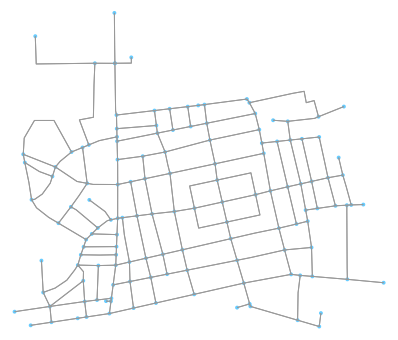

<Figure size 432x288 with 0 Axes>

In [7]:
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [0]:
# get the bounding area
area = ox.gdf_from_place(place_name)

In [0]:
# get information of buildings
buildings = ox.footprints_from_place(place_name)

In [10]:
type(area), type(buildings)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [0]:
# extract nodes and edges like a pandas dataframe
nodes_df, edges_df = ox.graph_to_gdfs(graph)

Let's analyze node data.

In [12]:
nodes_df.head()

,y,x,osmid,geometry
0,41.010094,28.969963,278005047,POINT (28.96996 41.01009)
1,41.010091,28.968678,2605667829,POINT (28.96868 41.01009)
2,41.009880,28.967444,2674464450,POINT (28.96744 41.00988)
3,41.009965,28.967458,2683365496,POINT (28.96746 41.00997)
4,41.009966,28.967413,2683365497,POINT (28.96741 41.00997)


In [0]:
# make a column having node number
nodes_df['node_no'] = np.arange(len(nodes_df))

In [14]:
nodes_df.head()

,y,x,osmid,geometry,node_no
0,41.010094,28.969963,278005047,POINT (28.96996 41.01009),0
1,41.010091,28.968678,2605667829,POINT (28.96868 41.01009),1
2,41.009880,28.967444,2674464450,POINT (28.96744 41.00988),2
3,41.009965,28.967458,2683365496,POINT (28.96746 41.00997),3
4,41.009966,28.967413,2683365497,POINT (28.96741 41.00997),4


Let's see how many nodes we have.

In [15]:
nodes_df.shape

(136, 5)

We have 136 nodes.

Time to analyze edge data.

In [16]:
edges_df.head()

,u,v,key,osmid,name,highway,oneway,length,geometry
0,0,25,0,303865763,Kalpakçılarbaşı Caddesi,pedestrian,False,28.087,"LINESTRING (28.96996 41.01009, 28.96995 41.010..."
1,1,6,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,37.116,"LINESTRING (28.96868 41.01009, 28.96911 41.01015)"
2,1,61,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,39.205,"LINESTRING (28.96868 41.01009, 28.96822 41.01001)"
3,1,57,0,262668172,NaN,pedestrian,False,16.654,"LINESTRING (28.96868 41.01009, 28.96873 41.00995)"
4,1,33,0,303865759,Kolancılar Sokak,pedestrian,False,18.339,"LINESTRING (28.96868 41.01009, 28.96862 41.01025)"


In [17]:
type(edges_df)

geopandas.geodataframe.GeoDataFrame

In [18]:
edges_df.shape

(414, 9)

We have 414 edges in the graph.

Now let's visualize the collected geo data

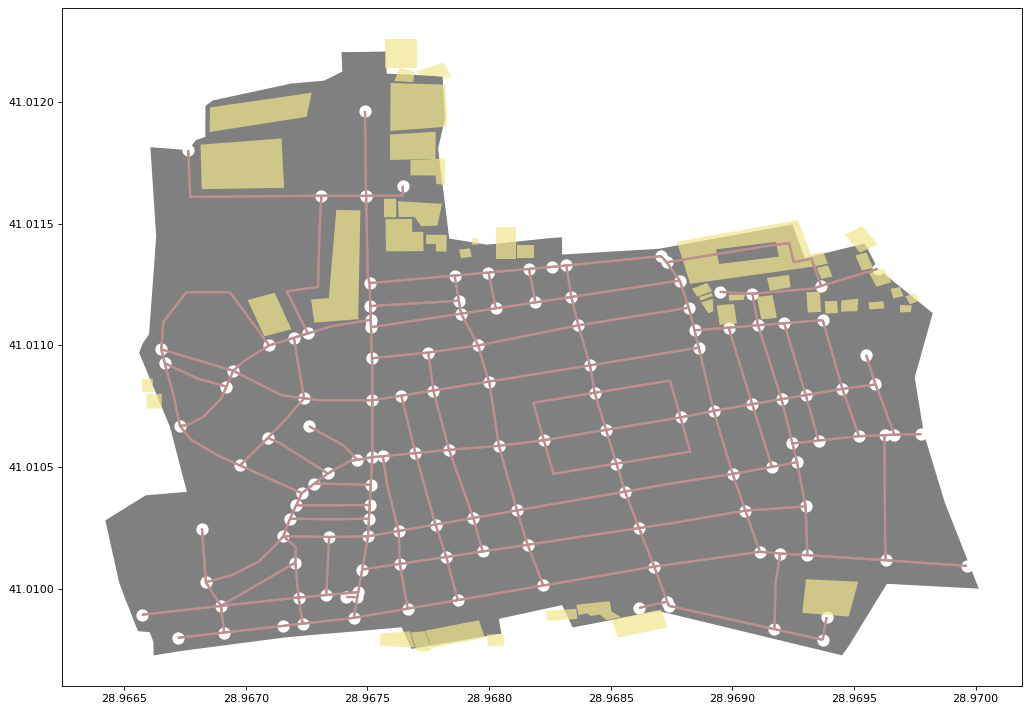

In [19]:
fig, ax = plt.subplots(figsize=(14, 9), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
nodes_df.plot(ax=ax, linewidth=5, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
plt.tight_layout()

## Heat map

In this approach I need to classify all the nodes based on the risk of passing through the node, which is based on the heat map. But we are still working on the heat map I will be using fake data for that.

I am rating each node such that 0 means less risky and 5 means very much risky.

In [0]:
# array of length = number of nodes
danger = np.zeros(len(nodes_df))

In [0]:
def rate(rate, frequency, data):

    '''
    function to manipulate data array.

    rate : rate of risk Eg.(0-5)
    frequency : how many time the element in the array to be manipulated.
    data : numpy array holding the data
    '''
    for i in range(frequency):
        idx = np.random.randint(0, data.shape[0])
        data[idx] = rate

    return data

In [47]:
# manipulate the array of zeros
danger = rate(1, 64, danger)
danger = rate(2, 32, danger)
danger = rate(3, 16, danger)
danger = rate(4, 8, danger)
danger = rate(5, 4, danger)
danger

array([3., 1., 2., 1., 2., 0., 3., 0., 2., 1., 0., 1., 2., 1., 0., 0., 2.,
       0., 5., 0., 1., 0., 3., 0., 0., 0., 2., 5., 1., 1., 0., 0., 0., 0.,
       4., 0., 0., 2., 2., 3., 4., 0., 4., 2., 1., 3., 1., 2., 2., 0., 1.,
       0., 2., 3., 3., 0., 0., 1., 0., 1., 2., 0., 4., 0., 0., 2., 0., 1.,
       0., 0., 1., 3., 2., 0., 1., 0., 0., 4., 2., 5., 0., 1., 0., 1., 1.,
       0., 3., 4., 0., 2., 0., 0., 1., 2., 0., 4., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 3., 5.,
       1., 3., 2., 1., 0., 1., 2., 3., 0., 3., 0., 1., 2., 2., 0., 0., 2.])

In [48]:
# write this information to the node dataframe
nodes_df['risk_rate'] = danger
nodes_df.head()

,y,x,osmid,geometry,node_no,risk_rate
0,41.010094,28.969963,278005047,POINT (28.96996 41.01009),0,3.0
1,41.010091,28.968678,2605667829,POINT (28.96868 41.01009),1,1.0
2,41.009880,28.967444,2674464450,POINT (28.96744 41.00988),2,2.0
3,41.009965,28.967458,2683365496,POINT (28.96746 41.00997),3,1.0
4,41.009966,28.967413,2683365497,POINT (28.96741 41.00997),4,2.0


Now let's visualize the nodes based on the risk rate.

In [0]:
import matplotlib.colors as colors

cmap = colors.ListedColormap(['green','yellow', 'blue', 'violet','orange', 'red'])
boundaries = [0, 1, 2, 3, 4, 5, 6]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

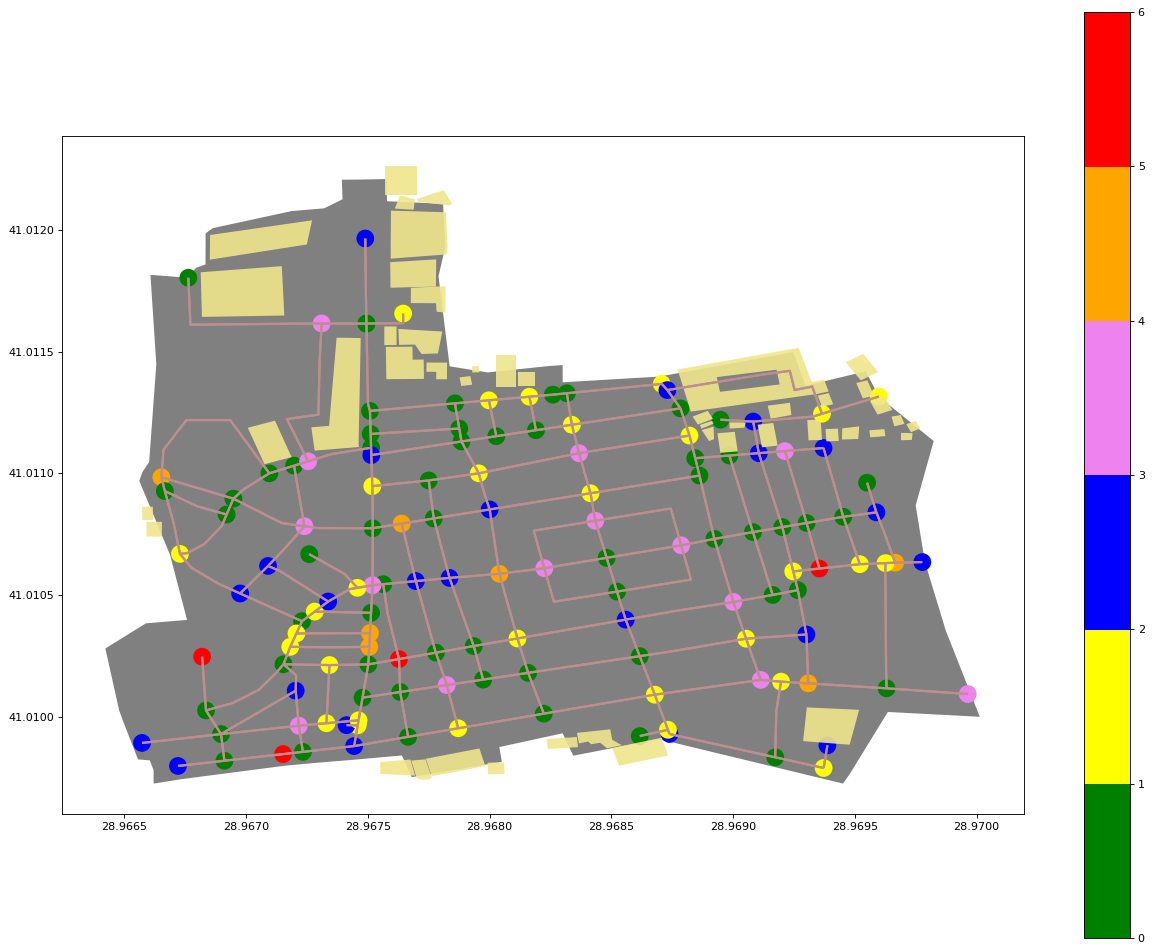

In [50]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
nodes_df.plot(ax=ax, linewidth=10, column='risk_rate', cmap=cmap, norm=norm)
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

## Graph for Analysis

In this section I will convert the nodes and edges in the geo data to a networkx graph.

In [0]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
%matplotlib inline

In [28]:
edges = [(edges_df.u[i], edges_df.v[i])for i in range(edges_df.shape[0])]
edges[:5]

[(0, 25), (1, 6), (1, 61), (1, 57), (1, 33)]

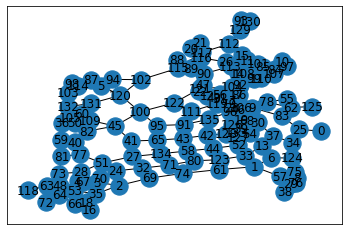

In [29]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

## Q-Learning

Let's find the **safe route from node 0 to 120**.

So initialize Reward and Q-matrix.

In [51]:
# reward matrix with all elements initialized to zero and shape (no. of nodes X no. of nodes)
R = np.matrix(np.zeros(shape=(nodes_df.shape[0], nodes_df.shape[0])))
R

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

**Reward Logic**
- If I am going from a less risky node to a high risky node give a small negative reward proportional to the risk difference.
- If I am going from a high risky node to a less risky node give a small positive reward proportional to the risk difference.
- Give a high positive reward to all actions arriving destination node. (here it is node number 120)

In [0]:
# first 2 logics are implemented below
for i in range(nodes_df.shape[0]):
    for j in range(nodes_df.shape[0]):
        from_node_risk = int(nodes_df[nodes_df.node_no == i]['risk_rate'])
        to_node_risk = int(nodes_df[nodes_df.node_no == j]['risk_rate'])
        if (to_node_risk > from_node_risk):
            R[i,j] = -2*(to_node_risk-from_node_risk)
        else:
            R[i,j] = from_node_risk-to_node_risk

In [53]:
# set high reward to actions arriving at node 120
for x in G[120]:
    R[x, 120] = 100

pd.DataFrame(R)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,0.0,2.0,1.0,2.0,1.0,3.0,0.0,3.0,1.0,2.0,3.0,2.0,1.0,2.0,3.0,3.0,1.0,3.0,-4.0,3.0,2.0,3.0,0.0,3.0,3.0,3.0,1.0,-4.0,2.0,2.0,3.0,3.0,3.0,3.0,-2.0,3.0,3.0,1.0,1.0,0.0,...,2.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,0.0,-4.0,2.0,0.0,1.0,2.0,3.0,2.0,1.0,0.0,3.0,0.0,3.0,2.0,1.0,1.0,3.0,3.0,1.0
1,-4.0,0.0,-2.0,0.0,-2.0,1.0,-4.0,1.0,-2.0,0.0,1.0,0.0,-2.0,0.0,1.0,1.0,-2.0,1.0,-8.0,1.0,0.0,1.0,-4.0,1.0,1.0,1.0,-2.0,-8.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,-2.0,-2.0,-4.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-4.0,0.0,-4.0,-8.0,0.0,-4.0,-2.0,0.0,1.0,0.0,-2.0,-4.0,1.0,-4.0,1.0,0.0,-2.0,-2.0,1.0,1.0,-2.0
2,-2.0,1.0,0.0,1.0,0.0,2.0,-2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,-6.0,2.0,1.0,2.0,-2.0,2.0,2.0,2.0,0.0,-6.0,1.0,1.0,2.0,2.0,2.0,2.0,-4.0,2.0,2.0,0.0,0.0,-2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,-2.0,1.0,-2.0,-6.0,1.0,-2.0,0.0,1.0,2.0,1.0,0.0,-2.0,2.0,-2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
3,-4.0,0.0,-2.0,0.0,-2.0,1.0,-4.0,1.0,-2.0,0.0,1.0,0.0,-2.0,0.0,1.0,1.0,-2.0,1.0,-8.0,1.0,0.0,1.0,-4.0,1.0,1.0,1.0,-2.0,-8.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,-2.0,-2.0,-4.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-4.0,0.0,-4.0,-8.0,0.0,-4.0,-2.0,0.0,1.0,0.0,-2.0,-4.0,1.0,-4.0,1.0,0.0,-2.0,-2.0,1.0,1.0,-2.0
4,-2.0,1.0,0.0,1.0,0.0,2.0,-2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,-6.0,2.0,1.0,2.0,-2.0,2.0,2.0,2.0,0.0,-6.0,1.0,1.0,2.0,2.0,2.0,2.0,-4.0,2.0,2.0,0.0,0.0,-2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,-2.0,1.0,-2.0,-6.0,1.0,-2.0,0.0,1.0,2.0,1.0,0.0,-2.0,2.0,-2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-2.0,1.0,0.0,1.0,0.0,2.0,-2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,-6.0,2.0,1.0,2.0,-2.0,2.0,2.0,2.0,0.0,-6.0,1.0,1.0,2.0,2.0,2.0,2.0,-4.0,2.0,2.0,0.0,0.0,-2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,-2.0,1.0,-2.0,-6.0,1.0,100.0,0.0,1.0,2.0,1.0,0.0,-2.0,2.0,-2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
132,-2.0,1.0,0.0,1.0,0.0,2.0,-2.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,-6.0,2.0,1.0,2.0,-2.0,2.0,2.0,2.0,0.0,-6.0,1.0,1.0,2.0,2.0,2.0,2.0,-4.0,2.0,2.0,0.0,0.0,-2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,-2.0,1.0,-2.0,-6.0,1.0,-2.0,0.0,1.0,2.0,1.0,0.0,-2.0,2.0,-2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
133,-6.0,-2.0,-4.0,-2.0,-4.0,0.0,-6.0,0.0,-4.0,-2.0,0.0,-2.0,-4.0,-2.0,0.0,0.0,-4.0,0.0,-10.0,0.0,-2.0,0.0,-6.0,0.0,0.0,0.0,-4.0,-10.0,-2.0,-2.0,0.0,0.0,0.0,0.0,-8.0,0.0,0.0,-4.0,-4.0,-6.0,...,-2.0,-2.0,0.0,-2.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,-6.0,-2.0,-6.0,-10.0,-2.0,-6.0,-4.0,-2.0,0.0,-2.0,-4.0,-6.0,0.0,-6.0,0.0,-2.0,-4.0,-4.0,0.0,0.0,-4.0
134,-6.0,-2.0,-4.0,-2.0,-4.0,0.0,-6.0,0.0,-4.0,-2.0,0.0,-2.0,-4.0,-2.0,0.0,0.0,-4.0,0.0,-10.0,0.0,-2.0,0.0,-6.0,0.0,0.0,0.0,-4.0,-10.0,-2.0,-2.0,0.0,0.0,0.0,0.0,-8.0,0.0,0.0,-4.0,-4.0,-6.0,...,-2.0,-2.0,0.0,-2.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,-6.0,-2.0,-6.0,-10.0,-2.0,-6.0,-4.0,-2.0,0.0,-2.0,-4.0,-6.0,0.0,-6.0,0.0,-2.0,-4.0,-4.0,0.0,0.0,-4.0


**Q-Matrix initialization Logic**
- Impossible actions are set -100
- Rest are initilized to 0

In [54]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
Q = np.matrix(np.zeros(shape=(nodes_df.shape[0], nodes_df.shape[0])))
Q-=100
for node in G.nodes:
    for x in G[node]:
        Q[node, x] = 0
        Q[x, node] = 0
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0
132,-100.0,-100.0,-100.0,-100.0,-

In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def get_next_node(start, er):
    '''
    Define a function which takes a starting node and returns the next node.
    It also accepts an exploration rate for random exploration.
    Otherwise, it chooses action according to the highest Q value of the possible actions.
    '''
    random_value = random.uniform(0,1)

    if random_value<er:
        sample = list(G[start])
    else:
        sample = np.where(Q[start,] == np.max(Q[start,]))[1]

    next_node = int(np.random.choice(sample, 1))

    return next_node

In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def updateQ(node1, node2, lr, discount):
    '''
    Function for updating Q-value of the action taken.
    '''
    max_index = np.where(Q[node2,] == np.max(Q[node2,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    
    max_value = Q[node2, max_index]
    Q[node1, node2] = int((1-lr)*Q[node1, node2] + lr*(R[node1, node2] + discount*max_value))


In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def learn(er, lr, discount):
    '''
    Function to integrate all the steps in Q-learning for 100000 iteration.
    '''
    for i in range(100000):
        start = np.random.randint(0,nodes_df.shape[0])
        next_node = get_next_node(start, er)
        updateQ(start, next_node, lr, discount)
    
    print('Done..!')


In [58]:
learn(0.5, 0.8, 0.8)

Done..!


In [59]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,13.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,29.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,43.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,42.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,40.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,51.0,-100.0,31.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,42.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,279.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,177.0,-100.0,-100.0,-100.0
132,-100.0,-100.0,-10

In [0]:
def safe_path(begin, end):
    path = [begin]
    next_node = np.argmax(Q[begin,])
    while next_node != end:
        next_node = np.argmax(Q[next_node,])
        path.append(next_node)
    
    return path

In [61]:
path = safe_path(0,120)
path

[0, 34, 37, 13, 33, 123, 80, 58, 134, 65, 95, 100, 120]

In [0]:
def show_path(path):
    '''
    helper function for visualization
    '''
    x_line = []
    y_line = []
    for i in path:
        x, y = float(nodes_df[nodes_df.node_no == i]['x']), float(nodes_df[nodes_df.node_no == i]['y'])
        x_line.append(x)
        y_line.append(y)
    return x_line, y_line

In [0]:
# get x, y values of path
x_path, y_path = show_path(path)

Let's see our map with 'From' and 'To' locations.

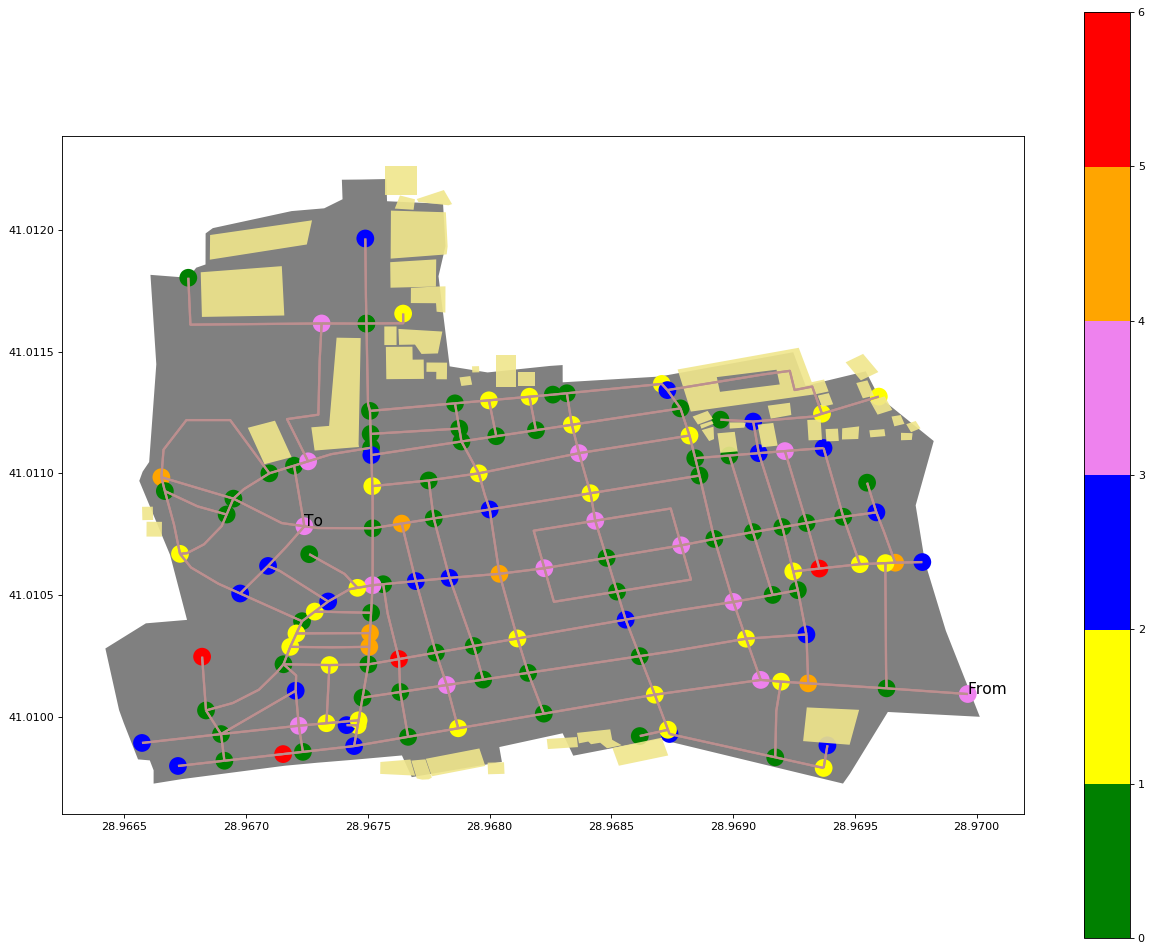

In [64]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
nodes_df.plot(ax=ax, linewidth=10, column='risk_rate', cmap=cmap, norm=norm)
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.text(x_path[0], y_path[0], 'From', color='black', fontsize=14)
plt.text(x_path[-1], y_path[-1], 'To', color='black', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

Now let's visualize the path..

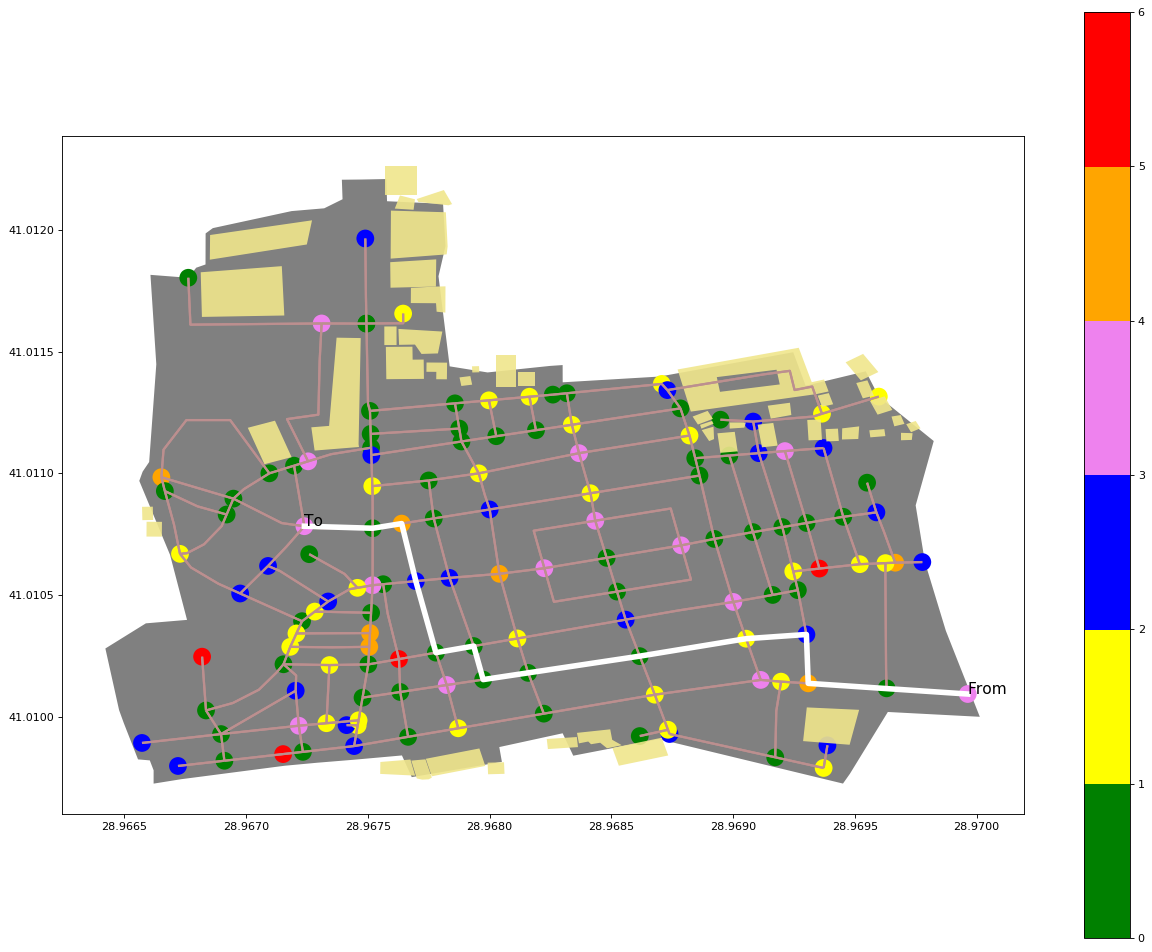

In [65]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
nodes_df.plot(ax=ax, linewidth=10, column='risk_rate', cmap=cmap, norm=norm)
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.plot(x_path, y_path, color='white', linewidth=5)
plt.text(x_path[0], y_path[0], 'From', color='black', fontsize=14)
plt.text(x_path[-1], y_path[-1], 'To', color='black', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

**Drawbacks**
- Does not consider whether the road passes through danger areas.(Only consider junctions and end points)

# References

- https://automating-gis-processes.github.io/CSC18/lessons/L1/Intro-Python-GIS.html
- https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
- https://matplotlib.org/tutorials/index.html